<a href="https://colab.research.google.com/github/JinnieL/Sentiment_Analysis/blob/main/KoBERT_%ED%99%98%EA%B2%BD_%EC%84%A4%EC%A0%95_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한글 깨짐 방지 설정

In [ ]:
# 한글 깨짐을 방지한 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# Colab 환경 세팅

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

# KoBERT 모델을 Colab에 설치하기

In [ ]:
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master        # onnxruntime version error
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
# !pip install onnxruntime

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-kpdwu29q/kobert-tokenizer_421ddc633f36480fae419a259e4e0193
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-kpdwu29q/kobert-tokenizer_421ddc633f36480fae419a259e4e0193
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [ ]:
# koBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

# Transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
!pip install numpy==1.23.1

In [ ]:
# Setting Library
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [ ]:
import numpy as np
import pandas as pd

# Colab GPU 활용
device = torch.device("cuda:0")

# Data Concatenation

In [ ]:
conv_df = pd.read_excel("/content/Data/감성대화말뭉치(최종데이터)_Training.xlsx")
conv_df.head(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,4,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,5,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN
5,6,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨.,진로에 대해서 고민하고 계시는군요. 어떤 점이 고민인가요?,직장 상사한테 자주 지적을 받아. 그럴 때마다 이 업무는 나랑 맞지 않는 거 같이 ...,업무가 나와 맞지 않아 시간을 버리는 것 같이 느껴지셨군요.,NaN,NaN
6,7,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해.,부모님의 노여움에 섭섭하시군요. 이런 상황을 어떻게 해결하면 좋을까요?,부모님께 좀 더 시간을 달라고 해야겠어. 진로 테스트를 받아볼까 생각 중이야.,진로 테스트를 받아보겠다고 부모님께 말씀드릴 생각이군요.,NaN,NaN
7,8,청년,여성,"진로,취업,직장",해당없음,기쁨,느긋,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,천천히라도 직장을 구해 보려고 하시는군요. 특별한 이유가 있으신가요?,더 좋은 회사가 기다리고 있을지도 모르는데 쉬고 있기가 좀 그래.,좋은 일자리를 놓치고 싶지 않아 끊임없이 노력하시는군요. 하는 일이 잘 풀리시길 바라요.,NaN,NaN
8,9,청년,여성,"진로,취업,직장",해당없음,불안,걱정스러운,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어.,취업에 대해 걱정이 되는군요.,응. 느긋함을 느끼는 내가 좀 싫었는데 걱정을 많이 하는 것보다는 낫다는 생각도 들어.,걱정보다는 느긋한 태도가 낫다고 생각하시는군요.,NaN,NaN
9,10,청년,여성,"진로,취업,직장",해당없음,기쁨,느긋,요즘 직장생활이 너무 편하고 좋은 것 같아!,직장생활이 편하고 좋으시다니 좋아 보여요. 다니고 계신 회사만의 장점이 있나요?,우리 회사는 복지가 정말 좋아! 내가 곧 출산하게 되는데 육아휴직 기간도 긴 데다가...,예비 엄마들에게는 정말 꿈의 회사인 것 같네요. 마음이 편하시겠어요.,NaN,NaN


In [ ]:
print(conv_df.shape)
print(conv_df.isnull().sum())

(51630, 13)
Unnamed: 0       0
연령               0
성별               0
상황키워드            0
신체질환             0
감정_대분류           0
감정_소분류           0
사람문장1            0
시스템문장1           0
사람문장2            0
시스템문장2           0
사람문장3         8935
시스템문장3        8935
dtype: int64


In [ ]:
conv_val_df = pd.read_excel("/content/Data/감성대화말뭉치(최종데이터)_Validation.xlsx")
conv_val_df.sample(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
4089,4090,중년,여성,건강,해당없음,슬픔,염세적인,이생에는 미련이 없어.,많이 외롭고 힘든 시간인가 봐요. 좀 더 자세히 설명해 주시겠어요?,주변을 돌아봐도 사람들이 행복해 보이지 않아 보여.,주변 사람들이 행복해 보이지 않아 보이는군요. 삶의 의욕을 높이기 위해 할 수 있는...,자꾸만 눈물이 나고 혼자 있고 싶지만 밖으로 나가볼까 해.,밖으로 나가서 분위기 전환도 하고 좀 더 행복한 마음이 들기를 바랄게요.
322,323,청년,남성,대인관계,해당없음,슬픔,후회되는,좋아하는 사람에게 고백을 안한 게 바보같이 느껴지고 후회가 돼.,고백하지 않았던 사실이 바보같이 느껴지고 후회가 되는군요.,매일 고백도 하지 못하고 짝사랑만 하는지 슬퍼서 눈물이 나.,짝사랑만 해서 슬프시군요. 지금의 기분에서 벗어나기 위해 무언가 할 수 있는 것은 ...,나가서 친구들과 수다 좀 떨고 와야겠어.,친구들과 수다로 지금보다 기분이 나아졌으면 좋겠어요.
5181,5182,청소년,여성,가족관계,해당없음,분노,악의적인,언니랑 방을 같이 쓰는데 언니 물건 때문에 너무 어수선해. 다 버려버리고 싶어.,언니의 물건 때문에 방이 어수선해서 불편하시겠어요. 갈등을 평화롭게 해결할 방법은 ...,언니한테 정리 좀 하라고 말해야겠어. 계속 이러면 나도 정말 못 참는다고.,갈등이 잘 해결되길 바라요.,NaN,NaN
6639,6640,청년,여성,"연애,결혼,출산",해당없음,당황,열등감,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,먼저 결혼한 친구가 부럽군요.,맞아. 그 친구와 비교하게 되니 자존감이 낮아지는 기분이야.,비교로 자존감이 낮아지는군요.,NaN,NaN
5869,5870,노년,여성,재정,만성질환 무,당황,혼란스러운,재정적으로 혼란스러워.,재정에 혼란스러우시군요.,돈이 너무 없어.,돈이 없어 고민이 많으시군요.,NaN,NaN
3448,3449,청년,남성,"진로,취업,직장",해당없음,불안,회의적인,과장님이 의견을 적극 피력해서 결정된 사안에 대해서 나는 의심이 들어.,과장님의 결정이 의심스러우시군요.,과장님이 사적인 감정으로 결정한 것 같아서 그래.,과장님이 사적인 감정이 개입된 것 같군요. 어떻게 하면 이 상황을 해결 할 수 있을까요?,과장님한테 결정하신 사안에 대해서 대화를 요청해야겠어.,대화로 상황이 잘 해결되길 바라요.
547,548,청년,남성,"진로,취업,직장",해당없음,분노,분노,용기를 내서 성적 지향성에 대해 이야기 했는데 모두가 나를 비난했어.,성적 지향성에 대해 이야기 하자 모두가 비난해서 화나셨겠어요.,성적 지향성에 대해 다른 점을 인정해 줬으면 좋겠는데 어떻게 해야 할지 고민이야.,고민이시군요. 어떻게 하는 것이 가장 좋은 방법일까요?,사람은 모두 다를 수 있기 때문에 인정해 줄 수 있도록 사람들과 대화로 풀어가는 것...,사람들과의 대화로 다른 점을 인정받았으면 좋겠네요.
4005,4006,청년,여성,"연애,결혼,출산",해당없음,분노,분노,남편이 얼마 전에 받은 퇴직금을 주식에 투자해 버렸대. 어이가 없다.,남편 분이 퇴직금을 모두 주식에 투자해 버렸군요. 화가 나시겠어요.,그것도 내게 말도 없이 몰래 퇴직금 전부를 써 버렸어. 황당해서 말도 안 나오네.,사용자님에게 말도 없이 퇴직금 전부를 써 버린 상황이군요. 어떻게 하시는 것이 좋을까요?,투자한 건 어쩔 수 없고 다시는 내게 말도 없이 이런 일을 못 벌이게 다짐을 받아야겠어.,다음에는 이런 일이 발생하지 않도록 다짐을 꼭 받을 수 있기를 바라요.
4846,4847,중년,여성,"대인관계(부부, 자녀)",해당없음,상처,충격 받은,얼마 전에 딸 때문에 충격을 크게 받았어.,따님하고 무슨 일이 있으셨어요?,벌써 몇 년 동안 사귄 남자가 있는데 나한테는 말을 한 번도 안 해주다가 이번에 들...,그런 일이라면 따님한테 서운하실 수도 있겠어요.,NaN,NaN
6354,6355,청년,남성,"연애,결혼,출산",해당없음,당황,남의 시선을 의식하는,나 고민이 생겼어.,무슨 고민인지 말씀해 주실 수 있나요?,여자친구랑 길거리에서 손도 잡고 싶고 팔짱도 끼고 싶은데 사람들의 시선이 너무 신경...,공공장소에서의 신체 접촉이 조심스러우시군요.,NaN,NaN


In [ ]:
print(conv_val_df.shape)
print(conv_val_df.isnull().sum())

(6641, 13)
Unnamed: 0       0
연령               0
성별               0
상황키워드            0
신체질환             0
감정_대분류           0
감정_소분류           0
사람문장1            0
시스템문장1           0
사람문장2            0
시스템문장2           0
사람문장3         1955
시스템문장3        1955
dtype: int64


감성대화말뭉치 train & validation data set과 단발성 데이터 셋을 모두 합친 뒤 train, validation, test 데이터 비율을 6 : 2 : 2로 split

In [ ]:
# train & validation data set concatenate
conv_df = pd.concat([conv_df, conv_val_df])
conv_df = conv_df.reset_index(drop=True)
conv_df.sample(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
54879,3250,노년,남성,"건강,죽음",만성질환 무,분노,분노,친구가 신호위반 차에 치여서 죽었다는 소식을 들으니 충격적이야.,신호위반 차량 운전자한테 화가 많이 나시겠어요.,매우 건강한 친구였는데 그런 사고로 인해 세상을 떠난 게 너무 안타까워.,지금의 기분에서 벗어나기 위해 무언가 할 수 있는 것은 있을까요?,나가서 친구들과 만나 이 기분을 풀어야겠어.,친구들과 대화로 기분이 괜찮아지면 좋겠어요.
31081,31082,청소년,여성,학업 및 진로,해당없음,상처,버려진,요즘 세상에 내가 할 수 있는 일이 아무것도 없는 것 같아서 마음이 아파.,할 수 있는 일이 없다고 느껴서 마음이 아프시군요.,잘하는 것도 없고 하고 싶은 것도 없어서 진로가 막막해.,진로가 막막하시군요. 이 문제에 관해 누구의 도움을 받을 수 있을까요?,이럴 땐 진로 담당 선생님께 상담을 요청하는 게 좋을 것 같아.,진로 담당 선생님과 상담을 하고 싶으시군요.
6846,6847,중년,남성,"대인관계(부부, 자녀)",해당없음,불안,조심스러운,아이들이 다 커서 벌써 중학생이야.,자녀들이 중학생이 되었군요.,이제 곧 사춘기가 올 텐데 어떻게 키워야 할지 고민이야.,사춘기를 겪을 생각에 고민이 많으시군요. 이 문제를 상담할 사람이 있나요?,누나한테 물어봐야겠어. 조카가 고등학생이거든.,누나에게 물어보실 생각이시군요. 도움이 되었으면 해요.
50409,50410,중년,남성,"대인관계(부부, 자녀)",해당없음,분노,방어적인,아내를 떠나보낸 뒤로 밖에 나가면 보이는 행복한 얼굴을 한 사람들이 부러워.,아내를 먼저 떠나보내 마음이 많이 슬프시겠어요.,아내가 떠난 게 모두 내 탓인 것 같다는 생각이 들어.,자신의 문제로 아내가 떠난 것 같아 힘드시겠군요. 어떻게 하면 기분이 나아질 수 있...,아내와 함께 걸었던 거리를 걸으면서 생각을 정리하고 싶어.,거리를 걸으면서 기분이 나아졌으면 좋겠어요.
31663,31664,노년,여성,대인관계,만성질환 유,당황,한심한,어제 남편에게 몹시 화를 냈는데 시간이 지나 생각해 보니 내가 잘못한 게 맞지 뭐야.,남편분에게 화를 내고는 미안하신가 봐요.,미안하기도 하고 한심하기도 하네. 노후도 불안정하고 몸까지 아프니 긍정적이기가 힘들어.,긍정적인 생각을 하기 힘들어서 화도 나고 스스로를 한심하게 생각하게 되었군요.,NaN,NaN
40458,40459,노년,여성,"건강,죽음",만성질환 무,상처,괴로워하는,내가 예전에 공부를 많이 못한게 후회돼.,뭔가를 지금이라도 배우고 싶은신 건가요?,이나이에 뭘 배우기는 그렇고 좀더 공부를 잘해서 좋은 직장에 다녔으면 해서.,좋은 직장에 다녔다면 어떤게 변화했을거라 생각하신는 건가요?,월급이 많으면 나중에 남편이랑 자식들 돌보는데 편하잖아.,그렇게 생각하시는군요.
25946,25947,노년,여성,재정,만성질환 무,불안,조심스러운,새로운 사업에 투자하고 싶은데 너무 조심스러워. 어떻게 해야 할지 모르겠어.,새로운 사업에 투자하고 싶은데 조심스러우시군요.,너무 불안해. 그 사업에 투자해도 될지 늘 고민해.,지금의 불안감을 해소할 수 있는 방법이 있을까요?,그 사업에 대해 더 잘 알아봐야지. 차근차근 공부를 해볼까 해.,공부를 할 계획이시군요.
21759,21760,청소년,여성,학업 및 진로,해당없음,기쁨,흥분,좋아하는 남자애에게 고백을 받았는데 내 인생 처음이라서 흥분돼.,처음 고백을 받아서 몹시 흥분하셨군요.,나도 관심 있는 애였는데 그 애가 고백을 하니까 너무 기쁜 거 있지.,어떻게 하면 이 기쁨을 계속 유지할 수 있을까요?,일단 나도 좋다고 했으니까 잘 사귀어 보고 싶어.,열심히 반복 학습을 해서 다음 시험도 좋은 결과를 노리시는군요.
40091,40092,노년,남성,"건강,죽음",만성질환 무,당황,외로운,요즈음 건강이 부쩍 나빠진 것 같아서 걱정이야.,그러시군요. 건강 진단은 받아보셨나요?,응. 특별한 질병은 없다고 하는 데 내가 건강관리를 잘 하지 못하고 무절제하게 산 ...,그러시군요. 건강을 위하여 특별히 신경을 쓰시는 일은 있으신가요?,그런 거 없지. 사는 것이 항상 불안하고 힘들지만 열심히 살려고 노력은 하고 있지.,그러시군요. 열심히 사는 것이 참 중요한 일인 것 같아요.
42988,42989,노년,남성,"건강,죽음",만성질환 무,당황,외로운,당뇨 합병증으로 건강이 더 나빠졌어. 정말 속상해.,당뇨 합병증으로 건강이 나빠져서 속상하시군요.,아내가 식단관리도 도와주고 지극정성으로 챙겨줬는데 나빠져서 미안한 마음이야.,아내가 당뇨 관리를 열심히 도와주셨는데 나빠져서 미안하시군요.,일단 건강이 일 순위니까 치료에 전념할 거야. 아내에게 미안하고 고맙다고도 말해야지.,아내에게 고마움과 미안함을 전하고 치료에 전념해서 건강해지시길 바라요.


  감정_대분류 감정_소분류  count
2     분노     분노   1141
5     슬픔     슬픔   1044
4     상처     상처   1028
3     불안     불안   1025
1     당황     당황    993
0     기쁨     기쁨    763


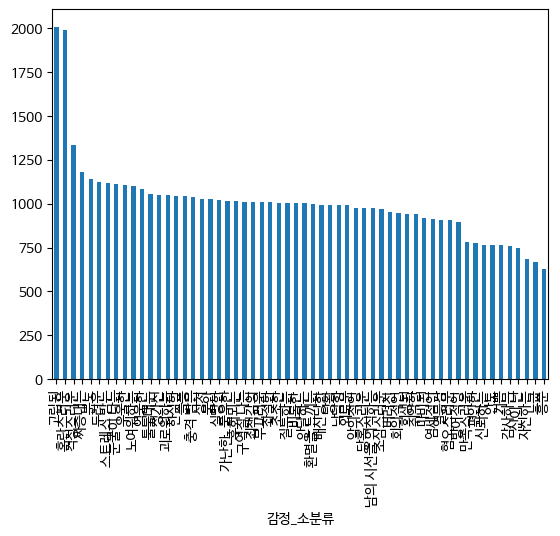

In [ ]:
# 감정 소분류 컬럼을 구성하는 레이블 비율 확인
conv_df['감정_소분류'].value_counts().plot(kind='bar')
print(conv_df[conv_df['감정_대분류'] == conv_df['감정_소분류']].groupby(['감정_대분류', '감정_소분류']).size().reset_index(name='count').sort_values(by='count', ascending=False))

In [ ]:
# 데이터 확인
conv_df[conv_df['감정_소분류'] == '방어적인'].sample(10)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
49059,49060,청소년,여성,학업 및 진로,해당없음,분노,방어적인,나는 인스타그램 중독이야. 나보다 잘난 사람들을 보면 내가 너무 싫어져.,인스타그램을 보면서 자신이 싫어지시군요.,나는 왜 이렇게 못났을까? 열등감 느껴지고 이런 내가 너무 싫어.,열등감을 느끼며 괴로워하시군요. 이 감정에서 벗어나려면 어떻게 해야 좋을까요?,인스타그램을 끊고 나의 장점에 대해 생각해보는 시간을 가져야겠어.,자신의 장점을 생각해보며 기분이 나아졌으면 좋겠어요!
45087,45088,청년,남성,대인관계,해당없음,분노,방어적인,가정에 불화가 생기는 게 전부 나 때문인 것 같아.,가정불화의 원인을 스스로라고 생각하시는군요.,내가 장애가 있기 때문에 그런 거야. 다들 나보다 잘났으니까!,지금 기분에서 벗어나기 위해서 무엇을 할 수 있을까요?,모르겠어. 일단 친구들과 이야기해서 기분을 풀고 와야겠어.,친구들과의 대화가 기분을 좋게 만들기를 바래요.
41940,41941,노년,남성,"건강,죽음",만성질환 무,분노,방어적인,아내의 병증이 점점 심해져 누가 항상 옆에서 보살펴 줘야 하는데 방법이 없네.,다른 가족 중 돌볼 사람이 없나요?,자녀들과 친척도 멀리 있어 도와줄 사람이 없네. 다 내 잘못 같아서 더 괴롭네.,자녀와 친척도 모두 멀리 있어서 도움을 받지 못하는군요.,얼마 전에 딸이 온다고 하는 것을 못 오게 했었거든 그게 더 후회되네. 지금이라도 ...,그러세요. 딸이 엄마 돌보면 엄마도 많이 좋아할 것 같네요.
40599,40600,노년,여성,재정,만성질환 무,분노,방어적인,요즘 나만 가난한 것 같아 열등감이 들어.,최근 열등감을 느끼시는군요. 어떤 일인지 자세히 말씀해주실 수 있으신가요?,집값이 너무 올라서 나만 내 집 마련을 하지 못했어.,내 집 마련을 하지 못하셔서 열등감을 느끼시는군요.,퇴직해서 수입도 없으니 이제는 포기해야만 하는 걸까?,이 문제를 상의할 가족분들이 있으실까요?
48063,48064,중년,남성,"대인관계(부부, 자녀)",해당없음,분노,방어적인,아내가 너무 갑작스럽게 죽어 황망해. 같이 사는 동안 아무것도 못 해줘서 너무 미안해.,같이 사는 동안 아내에게 아무것도 못 해줘서 미안하시군요.,바쁘단 핑계로 아내에게 너무 무심했어. 좀 더 표현하고 사랑해줬어야 했는데 후회돼.,사는 동안 표현을 많이 못 하셔서 후회가 되시는 군요. 앞으로 어떻게 하면 좋을까요?,앞으로 아이들에게 그리고 주변 사람들에게 더 신경 쓰려고 노력해야겠어.,주변 사람들에게 더 신경 쓰면서 잘 극복하기 바라요.
7400,7401,중년,남성,건강,해당없음,분노,방어적인,내 몸매가 괜찮은 것 같은데 아내는 운동이라도 하라고 성화야.,아내가 운동을 하라고 해서 화가 나시는군요.,작년까지 골프를 쳤는데 허리가 안 좋아서 그만뒀어.,골프를 좋아하시는데 허리가 아프셔서 잠깐 쉬고 계셨군요. 그럼 이제 허리는 괜찮아지...,조금 괜찮아져서 다시 골프를 치러 다녀볼까 해.,아내분의 말이 없었더라도 운동을 다시 할까 생각 중이셨던 거군요!
44104,44105,중년,남성,"직장, 업무 스트레스",해당없음,분노,방어적인,말이 좀 어눌하다고 사회생활 제대로 하지도 못하고 무시 받는 거 진짜 지긋지긋하다.,배려심 없는 사람들의 태도에 스트레스를 많이 받으신 것 같아요.,자기들이 나보다 얼마나 잘났다고. 열등감 느끼는 내가 문제지.,그런 대우를 받는 상황에서는 어떻게 대처해야 할까요?,그냥 이제 사람 마주칠 일을 안 만들래. 재택근무로 일자리를 알아보든가 해야겠어.,꼭 좋은 일자리를 구하시길 응원할게요!
57057,5428,중년,남성,"재정,은퇴,노후준비",해당없음,분노,방어적인,아무래도 노년을 위해 뭔가 준비해야겠어.,생각이 많으시네요. 어떤 준비를 하시겠어요?,재테크를 좀 알아봐야겠어.,훌륭하시네요. 좋은 결과 있기를 바랄게요.,NaN,NaN
39265,39266,노년,여성,재정,만성질환 무,분노,방어적인,나 요즘 기분이 계속 우울해.,기분이 우울하시다니 무슨 일 있었나요?,그냥 퇴직하고 나니 우리 애들이 날 무시하는 것 같은 기분이 들어.,자녀의 어떤 점이 무시하는 것 같은 마음이 들까요?,특별히 그런 행동은 없지만 그냥 내가 갑자기 하던 직장일이 없으니깐 무료했나봐. 무...,네 취미생활로 특별히 좋아하는 것이 있나요?
47089,47090,청년,여성,대인관계,해당없음,분노,방어적인,나도 이제 어른인데 부모님은 나를 아직도 애 취급해. 내가 많이 어려 보이나?,부모님께서 아이 취급을 하셔서 기분이 상하셨군요.,근데 나는 친구들보다 어린 것 같은 나 자신에게 열등감을 느껴. 나는 독립도 못 하...,열등감 때문에 괴로우시군요. 앞으로 어떻게 하는 것이 좋을까요?,내가 스스로 잘 할 수 있다는 걸 보여드려야겠어. 혼자서 잘 해낼 거야.,앞으로 열등감이 사라지고 혼자서 잘 해내는 모습 보여드리길 바라요.


첫번째 발화에는 감정이 드러나도록 생성된 데이터 셋이고 첫 문장 발화 이후 시스템 응답이나 후속 대화들은 상황에 따라 감정상태가 포함되지 않는 경우도 있음.    
→ 감정상태가 확실하게 드러난 '사람문장1' 컬럼과 '감정_대분류' 컬럼을 사용

In [ ]:
print(conv_df.shape)
print(conv_df.isnull().sum())

(58271, 13)
Unnamed: 0        0
연령                0
성별                0
상황키워드             0
신체질환              0
감정_대분류            0
감정_소분류            0
사람문장1             0
시스템문장1            0
사람문장2             0
시스템문장2            0
사람문장3         10890
시스템문장3        10890
dtype: int64


In [ ]:
# 사람문장1, 2, 3을 하나의 컬럼으로 생성
# conv_df['Sentence'] = conv_df[['사람문장1', '사람문장2', '사람문장3']].astype(str).agg(''.join, axis=1)
conv_df['Sentence'] = conv_df['사람문장1'].astype(str) + conv_df['사람문장2'].astype(str) + conv_df['사람문장3'].fillna('').astype(str)
conv_df['Sentence'][0]

'일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.'

In [ ]:
conv_df = conv_df[['Sentence', '감정_대분류']]
conv_df.sample(10)

,Sentence,감정_대분류
21568,스페인을 꼭 가고 싶었는데 아빠가 내년에 스페인으로 가족여행을 가자고 했어. 정말 ...,기쁨
53901,결혼을 준비 중인데 전세자금 대출을 못 받을 수 있을 것 같아 불안해.이번에 대출 ...,불안
4806,친구랑 목욕탕에 갔는데 내 몸이 너무 허약해 보여서 창피했어.응. 친구는 운동도 열...,당황
53276,의사가 항암치료가 효과가 있다고 하니 이제야 안심이 되네.항암치료가 너무 힘든데 그...,기쁨
16629,보건소에서 진료를 봤는데 검진 결과가 늦어지고 있어서 안달 나고 화가나.검진 결과가...,분노
10682,어제 제일 친한 친구랑 싸웠어. 화해해야 하는데 어떻게 해야 할지 모르겠어.이렇게 ...,불안
29938,이번 프로젝트 성공적이었다고 사장님께 격려금 받았어. 너무 기분 좋아.우리팀원들과 ...,기쁨
34945,결혼식에 내가 좋아하는 가수가 축가를 불러주기로 했어! 너무 기뻐.다이나믹듀오야. ...,기쁨
27077,아빠가 월급 보너스를 받더니 기분이 좋았나 봐. 용돈을 많이 주셨어.용돈으로 무엇을...,기쁨
10275,이력서를 서른 곳의 회사에 넣었는데 면접에서 다 탈락했어.응. 점점 자신감이 없어지...,불안


In [ ]:
# Warning 무시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# conv_df[conv_df['감정_대분류'] == conv_df['감정_소분류']].sample(10)

In [ ]:
# 감정 소분류 컬럼을 구성하는 레이블 비율 확인
# print(conv_df[conv_df['감정_대분류'] == conv_df['감정_소분류']].groupby(['감정_대분류', '감정_소분류']).size().reset_index(name='count').sort_values(by='count'))

In [ ]:
# # label 개수 비교
# conv_df['감정_대분류'].value_counts().plot(kind='bar')
# print(conv_df.groupby('감정_대분류').size().reset_index(name='count'))

In [ ]:
sent_df = pd.read_excel("/content/Data/한국어_단발성_대화_데이터셋.xlsx")
sent_df.head(10)

,Sentence,Emotion,Unnamed: 2,Unnamed: 3,Unnamed: 4,공포,5468
0,언니 동생으로 부르는게 맞는 일인가요..??,공포,NaN,NaN,NaN,놀람,5898.0
1,그냥 내 느낌일뿐겠지?,공포,NaN,NaN,NaN,분노,5665.0
2,아직너무초기라서 그런거죠?,공포,NaN,NaN,NaN,슬픔,5267.0
3,유치원버스 사고 낫다던데,공포,NaN,NaN,NaN,중립,4830.0
4,근데 원래이런거맞나요,공포,NaN,NaN,NaN,행복,6037.0
5,남자친구가 떠날까봐요,공포,NaN,NaN,NaN,혐오,5429.0
6,이거 했는데 허리가 아플수도 있나요? ;;,공포,NaN,NaN,NaN,Total,38594.0
7,내가불안해서꾸는걸까..,공포,NaN,NaN,NaN,NaN,NaN
8,일주일도 안 남았당...ㅠㅠ,공포,NaN,NaN,NaN,NaN,NaN
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포,NaN,NaN,NaN,NaN,NaN


In [ ]:
sent_df[['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4']].value_counts()

,,,count
Unnamed: 2,Unnamed: 3,Unnamed: 4,



Sentence와 Emotion 컬럼을 제외하고 삭제처리

In [ ]:
sent_df = sent_df[['Sentence', 'Emotion']]
sent_df.head(10)

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
5,남자친구가 떠날까봐요,공포
6,이거 했는데 허리가 아플수도 있나요? ;;,공포
7,내가불안해서꾸는걸까..,공포
8,일주일도 안 남았당...ㅠㅠ,공포
9,약은 최대한 안먹으려고 하는데좋은 음시있나요?0,공포


In [ ]:
print(sent_df.shape)
print(sent_df.isnull().sum())

(38594, 2)
Sentence    0
Emotion     0
dtype: int64


  Emotion  count
0      공포   5468
1      놀람   5898
2      분노   5665
3      슬픔   5267
4      중립   4830
5      행복   6037
6      혐오   5429


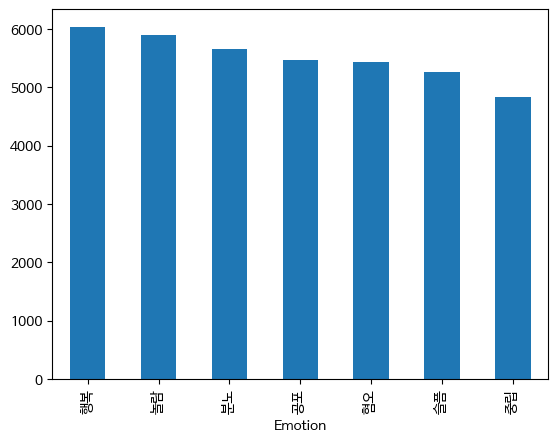

In [ ]:
# label 개수 비교
sent_df['Emotion'].value_counts().plot(kind='bar')
print(sent_df.groupby('Emotion').size().reset_index(name='count'))

In [ ]:
print(sent_df['Emotion'].value_counts())
print(sent_df['Emotion'].value_counts().sum())

Emotion
행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: count, dtype: int64
38594


1. 두 개 데이터 셋의 감정 레이블을 통일   
2. 데이터셋을 합치기
3. 레이블 카운트 다시 실행

In [ ]:
print(conv_df['감정_대분류'].unique())
print(sent_df['Emotion'].unique())

['분노' '기쁨' '불안' '당황' '슬픔' '상처']
['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']


In [ ]:
conv_df[conv_df['감정_대분류'] == '당황'].sample(10)

,Sentence,감정_대분류
4492,더 좋은 학교로 가고 싶어.지금 학교보다 좋은 학교가 있어. 그 학교로 가기 위해 ...,당황
32068,이 나이에 건강이 안 좋으니 부끄러워.체력이 많이 떨어지더라고.요즘은 조금만 걸어도...,당황
17329,요즘 회사에서의 규칙이 바뀌어서 적응하기가 힘들어.갑자기 출근시간이 빨라져서 아침에...,당황
36886,오늘 학교에서 폭력을 행사하는 친구를 봤는데 혐오스러웠어.그래서 그 벗을 도와주고 ...,당황
54290,평소 다니지 않던 노인정에 오랜만에 내가 나타나자 모두가 놀란 눈으로 쳐다보아서 당...,당황
39200,산책 갔다가 발을 헛디디어서 오른발 깁스한 지 두 달이 지났어.친구 험담하다가 흥분...,당황
56181,노후 자금이 부족한 것 같아 아무래도 개인연금을 들었어야 했나 봐.지금이라도 노후 ...,당황
5431,공무원 시험을 오랫동안 준비하다 보니 매일 혼자 있는 것 같아. 때로는 너무 외로워...,당황
52515,사귄 지 한 달 만에 남자친구가 결혼을 이야기하니까 당황스러워.적어도 일 년은 교제...,당황
12196,학교에서 혼자 밥을 먹는데 사람들이 날 어떻게 볼지 의식돼서 그게 창피해.쟨 외로운...,당황


In [ ]:
sent_df[sent_df['Emotion'] == '혐오'].sample(10)

,Sentence,Emotion
37700,한치의 반성의 기미조차 없네. 감옥이 편합갑다.,혐오
34977,한국은 계속 사과요구하고 돈받아도 더 달라그러는데 그에 비해 일본은 깔끔하네,혐오
37608,중궈들 자꾸 유입되면 한국도 1억인구 가능허다,혐오
37293,백인들이 공장에서 조립하는일 별로 안좋아할텐데..,혐오
37976,더러운 최태민이놈의 씨는 이렇게 말려없애야지,혐오
38034,범행당시 나이로서는 20년이 최고형이라잖슴..솔까 괘씸죄 포함해서 무기징역 때려도 ...,혐오
36971,"우리나라 처럼 언론 통제 당하고, 경제 완전 나빠져 봐야 정신 차리지.....",혐오
37949,ㅋㅋㅋㅋㅋㅋ사실이 이미 다 나와있는데 저걸 왜 부정하는지 원,혐오
35149,이런 뉴스보면 누진세 생각밖에 안난다,혐오
34465,응 다음 아이폰 부러워서 개 발광하는 폭탄노트7 나오세요,혐오


감성대화 말뭉치의 감정 label : 분노, 기쁨, 불안, 당황, 슬픔, 상처   
단발성 대화 세트의 감정 label : 공포, 놀람, 분노, 슬픔, 중립, 행복, 혐오    
두 데이터셋을 합치기 위해 감성대화 말뭉치의 label을 수정.

감정대화 말뭉치의 감정
- 분노 (유지)
- 기쁨 → 행복
- 불안 → 공포
- 상처 → 슬픔
- 당황 → 놀람

단발성 대화 세트의 감정
- 혐오 → 분노
- 중립 감정의 경우 데이터 균형성을 위해 일단 제거. 후에 활용 방안 다시 찾아볼것!

In [ ]:
sent_df[sent_df['Emotion'] == '중립'].sample(10)

,Sentence,Emotion
24073,더 필요한건 근혜와 순실이 대기업의 불법자금 추징하면 됨,중립
23895,사법부의 정점에 있는분들이 이렇게 쉬는날까지 모일 정도이니 어떤 선택을 하던 사회에...,중립
26730,얘들은 축구 DNA은 없는듯...,중립
24398,질문 이해 못할 듯,중립
26788,근데 서든2는 오버워치 없었어도 망했을 것 같다,중립
26741,현진이가 한화올때 데려오면 되겠네.,중립
25803,촛불의 황홀한 불빛에 야당인사들 막 달려드는구먼..그러다 촛불에 타죽는다..,중립
24579,일반장사 하는분들 부가세 받으며 불법이고 대기업에서 부가세 빋으며 합법?,중립
24132,130만원이면 아이패드 프로 128기가네,중립
25695,모태솔로라면 조금은 이해해줄게,중립


In [ ]:
# 기쁨 → 행복 / 불안 → 공포 / 상처 → 슬픔
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('기쁨', '행복')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('불안', '공포')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('상처', '슬픔')
conv_df['감정_대분류'] = conv_df['감정_대분류'].replace('당황', '놀람')
sent_df['Emotion'] =sent_df['Emotion'].replace('혐오', '분노')
print(conv_df['감정_대분류'].unique())

['분노' '행복' '공포' '놀람' '슬픔']


In [ ]:
# conv_df의 컬럼명 변경
conv_df = conv_df.rename(columns={'사람문장1': 'Sentence', '감정_대분류': 'Emotion'})
conv_df.sample(10)

,Sentence,Emotion
29045,아빠는 정말 귀찮고 성가셔.친구들이랑 노는데 자꾸 걱정된다면서 전화를 해.내가 뭐 ...,분노
10617,나 지금 망치로 머리를 한 대 얻어맞은 느낌이야.평소에 내가 싫어했던 선배 언니가 ...,슬픔
11411,아내가 임신했다고 연락이 왔어. 축복할 일이지만 너무 갑작스러워서 아무 일도 손에 ...,공포
42021,아직 인생 목표가 없어서 안절부절못하겠어.나도 목표를 가지고 살고 싶은데 정하기가 ...,공포
27366,자식들이 잘 챙겨주는 친구가 있는데 걔한테 열등감이 들어. 내 자식들은 나한테 관심...,슬픔
22781,막내아들이 요즘 너무 걱정이야.내가 조금만 뭐라 해도 울어버리니까 커서도 이럴까 봐...,놀람
40046,나 정말 슬픈 기분이야.못 배워서 할 수 있는 것이 없는 내가 지금껏 나를 돌보다 ...,슬픔
37597,우리 교실 내 왕따 당하는 친구는 없다고 자신해.다함께 이야기를 할 시간이 있어서 ...,행복
50950,무심코 던진 말에 친구가 마음에 상처를 입었나 봐.그 말이 상처가 될 줄 몰랐어. ...,슬픔
6439,오늘 회사에서 엄청 당황스러운 일이 있었어.잠깐 눈을 감고 생각하고 있었는데 내가 ...,놀람


In [ ]:
print(conv_df['Emotion'].value_counts())
print(conv_df['Emotion'].value_counts().sum())

Emotion
슬픔    20278
공포    10433
분노    10417
놀람     9804
행복     7339
Name: count, dtype: int64
58271


In [ ]:
# 당황 감정을 제외하고 일단 합쳐보기
sent_df = sent_df[sent_df['Emotion'] != '중립']
sent_df = sent_df.reset_index(drop=True)
print(sent_df['Emotion'].unique())

['공포' '놀람' '분노' '슬픔' '행복']


In [ ]:
# convDF와 sent_df 합치기
df = pd.concat([conv_df, sent_df])
df = df.reset_index(drop=True)
df.sample(10)

,Sentence,Emotion
4078,임신한 아내가 건강하게 출산을 할 수 있을지 걱정이야이번 주말에 아내와 함께 인터넷...,공포
24391,박 씨에게 정말 환멸을 느껴. 어린아이를 죽인 살인마야.박 씨가 음주운전을 하다가 ...,슬픔
89080,ㅋㅋㅋ 야이 개누리 새끼들아...니들도 인간은 아니네...개XXX들이야,분노
83918,언제나 밝은모습시원시원한 말씀프로의마인드 감사드립니다.,행복
1027,어깨가 뭉치고 아프다고 하니 딸이 안마기를 사줬어.기쁘고 고맙지. 안마해서 몸이 한...,행복
85007,이렇게 입법해서 법을 고쳐놓으면 간단하다!,행복
54489,몸이 아프니까 만사가 귀찮고 짜증이 나. 오늘도 애꿎은 아내에게 짜증을 냈어.거동이...,분노
37820,학업 잘하는 애만 대접받는 이런 세상이 꼭 필요가 있을까.학습 못하는 나 같은 애는...,슬픔
5390,엄마가 요즘 자꾸 친구 딸이 결혼한다고 나한테 시집 언제 가냐고 하셔. 나는 비혼주...,분노
26182,휴 정말 다행이지 뭐야.이번에 칠순잔치하는데 사람들이 별로 안 올까 봐 걱정을 많이...,행복


In [ ]:
print(df.shape)
print(df.isnull().sum())

(92035, 2)
Sentence    0
Emotion     0
dtype: int64


  Emotion  count
0      공포  15901
1      놀람  15702
2      분노  21511
3      슬픔  25545
4      행복  13376


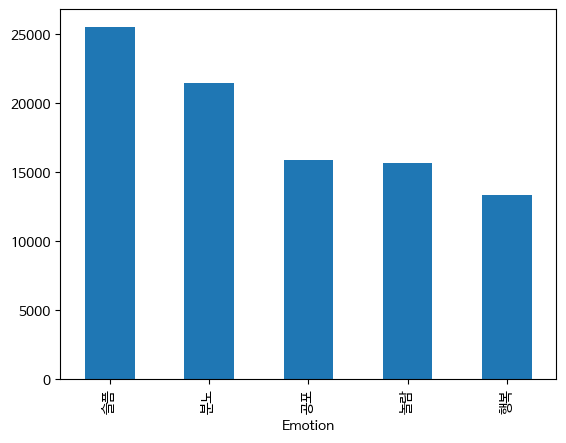

In [ ]:
# label 개수 비교
df['Emotion'].value_counts().plot(kind='bar')
print(df.groupby('Emotion').size().reset_index(name='count'))

In [ ]:
print(len(df[df['Emotion'] == '슬픔']) /len(df[df['Emotion'] == '행복']))

1.9097637559808613


Target Column label 별로 숫자 부여

In [ ]:
# Emotion 컬럼 정수로 변환

emotion_dict = {'공포': 0, '놀람': 1, '분노': 2, '슬픔': 3, '행복': 4}
df['Emotion_dict'] = df['Emotion'].map(emotion_dict)
df.sample(10)

,Sentence,Emotion,Emotion_dict
39407,자꾸 힘이 떨어지는 걸 느껴.직장에서 얼마 못 견디고 그만두게 되거든.진작 체력관리...,분노,2
25225,남편이 마지막 항암치료를 받는데 너무 고통스러워해서 내 마음이 너무 아파.고통스러워...,슬픔,3
35739,내 친구는 반드시 날 배반하지 않을 거라는 신뢰감이 들었어.내가 없는 데에서도 욕을...,행복,4
45874,공부할 때 새어머니가 오셔서 과일을 주시는데 공부하는데 집중하기가 힘들어.어머니랑 ...,공포,0
49221,무릎이 많이 약해진 것 같아. 움직이는 게 힘들어.난 아직 건강하다고 생각했는데 무...,슬픔,3
84053,기아하고는 전혀 상관없는데 잘 키워,행복,4
54967,내 치료비에 대해 막내딸에게 말했는데 형편이 좋지 않아 어렵다고 거절했어.저번에 첫...,슬픔,3
80900,기도하는 입보다 돕는 손이 더 이쁘다.,행복,4
45065,아버지께서 술을 드시고 오셔서 폭언을 하셔서 너무 힘들어.이 상황이 나아질 거 같지...,슬픔,3
69593,나라를 팔아먹다니..,놀람,1


In [ ]:
# 합친 데이터 저장
df.to_csv('/content/Data/concated_df.csv', index=False)

In [ ]:
# 확인
df = pd.read_csv('/content/Data/concated_df.csv')
df.sample(10)

,Sentence,Emotion,Emotion_dict
54304,기술직으로 먹고사는 게 자부심이 들 때도 있지만 이따금 무시를 당하는 거 같아 화가...,분노,2
85069,형님 축하드립니다!!,행복,4
50846,요즘 회사에 신입생들이 나보다 더 일 처리를 잘하는 거 같아서 스트레스받아.나보다 ...,공포,0
56286,로또에 당첨됐어.은퇴 후 살 전원주택을 사는 데 쓸 생각이야.,행복,4
57446,매일 바쁘게 사는데도 외로워.기쁘거나 속상한 일이 있어도 마음 터놓고 이야기할 친구...,놀람,1
15656,관절염이 있어서 짐을 어떻게 갖고 가나 걱정했는데 한 아가씨가 도와줘서 다행이다 싶...,행복,4
32355,엄마가 지금 내 방에 들어가서 문을 잠갔어. 일기장에 엄마 아빠가 싸운다는 내용을 ...,공포,0
20122,고혈압과 당뇨로 사소한 일에도 건강을 염두 하는 것이 지겨워.음식을 맘대로 못먹는게...,슬픔,3
66058,이젠 고등어탓도 하네 ㅋㅋㅋㅋㅋㅋㅋㄱㄱㅋㅋㅋㅋ,놀람,1
33881,친구가 나보다 좋은 차를 샀다면서 자랑하는데 화가 났어.내가 가진 차를 비하하면서 ...,분노,2


# Data Preprocessing

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/Data/concated_df.csv')
df.sample(10)

,Sentence,Emotion,Emotion_dict
11445,여자친구가 바람을 피우는 현장을 잡았어. 도저히 참을 수가 없어. 이 둘을 내가 가...,분노,2
54815,어머니께서 안락사를 부탁하셨어. 부탁을 들어드리자니 어머니를 포기하는 것 같아서 죄...,놀람,1
25605,투병 생활 끝에 드디어 암을 이겨내서 정말 기뻐.암을 선고받았었는데 자식들이 고맙게...,행복,4
57431,요즘 처와 딸 사이가 좋아지는 것 같아서 다행이야.응. 다행이지.,행복,4
22499,내가 임신한 후 요즘 남편이 일찍 집으로 들어와서 같이 시간을 보내고 있어.진정한 ...,행복,4
26350,어제 친구와 만났는데 친구가 갑자기 화를 내며 집에 가버렸어.친하다고 생각했는데 갑...,슬픔,3
584,남편이랑 이혼하려고 하는데 아이들이 다 내가 아닌 아빠를 따라가겠다고 해서 씁쓸하네...,놀람,1
52289,기관지가 안 좋아 기관지염이 있는데 의사가 권해준 차를 마셔서 기침이 줄어서 기분이...,행복,4
74196,종북 나불거리는 죵자들 혀바닥 뽑고싶다,분노,2
68935,무슨 소주안주 생선이 1억이나 하냐ㅋ,놀람,1


In [ ]:
# 모델링에 사용할 Sentence, Emotion_dict 컬럼만 사용
df = df[['Sentence', 'Emotion_dict']]
df.sample(10)

,Sentence,Emotion_dict
61782,진짜 무슨 무식을 넘어서 사이비종교단체같다,0
33887,친구가 이번에 좋은 직장에 들어갔는데 기분이 나빠.내가 정말 가고 싶었던 회사인데 ...,2
775,우리 집에 올 때마다 냉장고에 있는 걸 다 꺼내먹고 어지르는 친구 때문에 화가 나....,2
27998,나는 회의에서도 의견을 내기보다는 다른 사람의 의견을 보조하는 쪽이야.기분이 별로지...,2
10925,나이를 먹을수록 사람에 대한 경계와 의심이 많아지는 것 같아.누군가 나한테 베푸는 ...,2
4654,오늘 약속을 취소하고 집에만 있었어.아니. 약속을 잡아서 나가면 돈을 너무 많이 쓰...,3
7711,오늘 보험 상담하다가 좀 부끄러웠어.은퇴 준비와 노후설계를 위해 만났는데 나를 혼내...,1
14775,아빠는 주말마다 맛있는 요리를 해주셔서 너무 좋아.응. 나도 아빠 같은 남자를 만나...,4
19775,친구들에게 학교에서 따돌림을 당할 때 마다 내 자신에게 매일 실망스러워.응. 친구들...,3
69976,아 날씨 참 죷같네,2


KoBERT는 text, label 형식으로 입력해야하기 때문에 df 데이터 프레임의 Sentence와 Emotion_dict를 묶은 데이터셋을 생성

In [ ]:
# text, label로 묶인 data list 생성
data_list = []
for q, label in zip(df['Sentence'], df['Emotion_dict'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

## Split train & test data set

In [ ]:
# 데이터 분리 (Train & Test)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_list, test_size=0.2, random_state=2024, stratify=df['Emotion_dict'])
print(len(train_df))
print(len(test_df))

73628
18407


## Tokenization
KoBERT 오픈소스 내 예제 코드 및 블로그 참조

In [ ]:
#  BERTDataset : 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수.
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
# parameter setting
max_len = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
# tokenizer 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
# TypeError: BERTSentenceTransform.__init__() got an unexpected keyword argument 'vocab' 오류 해결 (KoBERT finetuning 오픈소스 예시 코드)
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
# BERTDataset : 데이터가 BERT 모델의 입력으로 들어갈 수 있도록 tokenization, int encoding, padding하는 함수.
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# BERTDataset에 split된 데이터 입력, input 형식에 맞도록 변환하기
# from kobert import get_tokenizer

# tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(train_df, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test_df, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
# 위에서 변환한 데이터를 torch 형식으로 변환
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

# KoBERT 모델 구현

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 5,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
# optimizer와 schedule 설정
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


In [ ]:
# calc_accuracy : 정확도 측정을 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# Model Training

In [ ]:
train_history = []
test_history = []
loss_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape, out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # train_history.append(train_acc / (batch_id+1))

    # .eval() : nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    # 즉, model이 Dropout이나 BatNorm2d를 사용하는 경우, train 시에는 사용하지만 evaluation을 할 때에는 사용하지 않도록 설정해주는 함수
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.7081022262573242 train acc 0.171875
epoch 1 batch id 201 loss 1.3354512453079224 train acc 0.3396299751243781
epoch 1 batch id 401 loss 1.1581238508224487 train acc 0.4712437655860349
epoch 1 batch id 601 loss 1.001213788986206 train acc 0.5353057404326124
epoch 1 batch id 801 loss 0.6769780516624451 train acc 0.5710245006242197
epoch 1 batch id 1001 loss 0.8456138372421265 train acc 0.5933597652347652
epoch 1 train acc 0.6060122409085268


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 1 test acc 0.6904422075320513


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9102758169174194 train acc 0.671875
epoch 2 batch id 201 loss 0.8550449013710022 train acc 0.7016480099502488
epoch 2 batch id 401 loss 0.8126185536384583 train acc 0.7070994389027432
epoch 2 batch id 601 loss 0.5957632064819336 train acc 0.7165921381031614
epoch 2 batch id 801 loss 0.5006609559059143 train acc 0.7244655118601748
epoch 2 batch id 1001 loss 0.603715181350708 train acc 0.7296765734265734
epoch 2 train acc 0.7339813205907906


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 2 test acc 0.7089426415598291


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7221871614456177 train acc 0.734375
epoch 3 batch id 201 loss 0.6397198438644409 train acc 0.7649253731343284
epoch 3 batch id 401 loss 0.7261101007461548 train acc 0.7704177057356608
epoch 3 batch id 601 loss 0.4436216950416565 train acc 0.7794041181364393
epoch 3 batch id 801 loss 0.2724553942680359 train acc 0.7862242509363296
epoch 3 batch id 1001 loss 0.4783633053302765 train acc 0.7912712287712288
epoch 3 train acc 0.7953138575152042


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 3 test acc 0.7183632701210826


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5885301232337952 train acc 0.78125
epoch 4 batch id 201 loss 0.6133396625518799 train acc 0.8274253731343284
epoch 4 batch id 401 loss 0.4718674421310425 train acc 0.8340087281795511
epoch 4 batch id 601 loss 0.33079755306243896 train acc 0.841202163061564
epoch 4 batch id 801 loss 0.21444980800151825 train acc 0.8448423845193508
epoch 4 batch id 1001 loss 0.4198611080646515 train acc 0.8481206293706294
epoch 4 train acc 0.8507489605312151


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 4 test acc 0.7197196069266382


  0%|          | 0/1151 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.45645713806152344 train acc 0.8125
epoch 5 batch id 201 loss 0.43563300371170044 train acc 0.869014303482587
epoch 5 batch id 401 loss 0.4476492404937744 train acc 0.8735972568578554
epoch 5 batch id 601 loss 0.19935882091522217 train acc 0.8791857321131448
epoch 5 batch id 801 loss 0.15642046928405762 train acc 0.8812812109862672
epoch 5 batch id 1001 loss 0.2999487817287445 train acc 0.8817744755244755
epoch 5 train acc 0.8828154089611517


  0%|          | 0/288 [00:00<?, ?it/s]

epoch 5 test acc 0.7184175235933048


In [ ]:
# 소프트 맥스 함수를 사용하여 각 label이 나올 확률을 계산
# softmax 함수 직접 작성
def new_softmax(a) :
  c = np.max(a)
  exp_a = np.exp(a-c)
  sum_exp_a = np.sum(exp_a)
  y = (exp_a / sum_exp_a)*100
  return np.round(y, 3)


In [ ]:
# # pytorch에서 제공하는 softmax 사용
# softmax = F.softmax()
# print(torchfn.softmax(dataset, dim=0))
# print(torchfn.softmax(dataset, dim=0).sum())

# Save Model

In [ ]:
#구글드라이브 연동
# from google.colab import drive
# drive.mount('/content/drive')

# 현재경로 /content/

import os
os.chdir('/content/drive/MyDrive/models/')
os.getcwd()

path = '/content/drive/MyDrive/models/'
torch.save(model, path + 'semtiment_analysis_model.pt')  # 전체 모델 저장

torch.save(model.state_dict(), 'semtiment_analysis_model_state_dict.pt')  # 모델 객체의 state_dict 저장

torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, 'sentiment_analysis_model_all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

# Load Model

In [ ]:
import os
from transformers import AdamW
os.chdir('/content/drive/MyDrive/models/')

model1 = torch.load('semtiment_analysis_model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model1.load_state_dict(torch.load('semtiment_analysis_model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model1.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model1.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

checkpoint = torch.load('sentiment_analysis_model_all.tar')   # dict 불러오기
model1.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Model Test

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("행복이")

        # print("이 결과는 뭐지?" + test_eval[0])
        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
# softmax 함수를 적용하여 확률값 계산하는 predict 정의
def predict_with_prob(predict_sentence):
    # 확률값 높은 감정 출력을 위한 label 작성
    labels = ['공포', '놀람', '분노', '슬픔', '행복']

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        # softmax 함수 적용하여 확률값 계산
        # probability = []
        # logits = np.round(new_softmax(logits), 3).tolist()
        # for logit in logits :
        #   probability.append(np.round(logit, 3))
        # print(probability)
        probabilities = F.softmax(out, dim=1)

        for prob in probabilities :
          # tensor를 CPU로 이동하고 numpy 배열로 변환
          prob_np = prob.cpu().detach().numpy()

          # label, 확률 numpy 배열(prob_np) 크기순 정렬
          sorted_indices = np.argsort(prob_np)[::-1]
          labels_sorted = [labels[i] for i in sorted_indices]
          prob_sorted = prob_np[sorted_indices]

          # print(">> 입력하신 내용에서 주로" + labels[torch.argmax(prob).item()] + "에 대한 감정일 확률이 " + str(np.round(prob_np * 100, 2)) + "%입니다.")
          print(">>> 입력하신 내용에서 ")
          for label, prob in zip(labels_sorted, prob_sorted):
            print(f"{label} : {np.round(prob * 100, 2)}%")
          print("가 느껴집니다. ")


[0.352, 0.19, 99.161, 0.192, 0.104]
[공포, 놀람, 분노, 슬픔, 행복]


sum([0.352, 0.19, 99.161, 0.192, 0.104])

In [ ]:
# 입력 문장의 상위 3개 감정까지 return

'공포': 0, '놀람': 1, '분노': 2, '슬픔': 3, '행복': 4

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 위로 고마워. 과연 그런 날이 올까?
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 우리도 좋은 곳으로 갔을 거라고 생각해. 하지만 너무 보고 시어
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 사실 자주 만나는 친구는 아닌데, 얘 솔직히 약속 잡을 때마다 이랬어
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 대체 어떤 미친놈들이 키우던 강아지를 버려?
>> 입력하신 내용에서 분노가 느껴집니다.


하고싶은 말을 입력해주세요 : 나는 잘하는게 아무것도 없나봐
>> 입력하신 내용에서 공포가 느껴집니다.


하고싶은 말을 입력해주세요 : 지금은 괜찮으셔 하지만 병원에 며칠 입원하셔야해
>> 입력하신 내용에서 공포가 느껴집니다.


하고싶은 말을 입력해주세요 : 저녁으로 먹은 팟타이가 매웠다. 근데 너무 맛있는걸 어떡하지
>> 입력하신 내용에서 공포가 느껴집니다.


하고싶은 말을 입력해주세요 : 팟타이가 맛있었다는게 핵심이란다?
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 팟타이가 맛있었다는게 핵심이라고
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 아 이거 안되겠네 진짜
>> 입력하신 내용에서 분노가 느껴집니다.


하고싶은 말을 입력해주세요 : 0


In [ ]:

#질문 무한반복하기! 0 입력시 종료 - 확률값 출력 버전
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict_with_prob(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 나 집에 언제 가지 내 침대가 홀로 어둠속에서 떨고 있어서 어서 지켜주러 가야해
>>> 입력하신 내용에서 
슬픔 : 90.51%
놀람 : 6.58%
공포 : 2.5%
분노 : 0.28%
행복 : 0.13%
가 느껴집니다. 


하고싶은 말을 입력해주세요 : 만사가 다 귀찮다
>>> 입력하신 내용에서 
분노 : 98.87%
공포 : 0.58%
슬픔 : 0.31%
놀람 : 0.15%
행복 : 0.09%
가 느껴집니다. 


하고싶은 말을 입력해주세요 : 앞으로 너를 손봐줄 일만 남은것 같네ㅎㅎ
>>> 입력하신 내용에서 
슬픔 : 49.23%
분노 : 41.31%
공포 : 4.15%
행복 : 3.27%
놀람 : 2.03%
가 느껴집니다. 


하고싶은 말을 입력해주세요 : 너 제대로 분류 못하면 싹 다 갈아버린다?
>>> 입력하신 내용에서 
놀람 : 52.46%
분노 : 41.83%
공포 : 5.2%
슬픔 : 0.36%
행복 : 0.15%
가 느껴집니다. 


하고싶은 말을 입력해주세요 : 뭔 물음표만 붙이면 죄다 놀람인줄 알아 이 바보야
>>> 입력하신 내용에서 
분노 : 98.29%
슬픔 : 0.97%
놀람 : 0.43%
공포 : 0.26%
행복 : 0.05%
가 느껴집니다. 


하고싶은 말을 입력해주세요 : 0


In [ ]:
sum([0.352, 0.19, 99.161, 0.192, 0.104])

99.999